# Import Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
import pickle
with open('data/clean_enron_spam_data.pkl', 'rb') as file:
    df = pickle.load(file)

df

,msg_freq_000,msg_freq_100,msg_freq_2000,msg_freq_2000 pm,msg_freq_2001,msg_freq_2001 pm,msg_freq_2004,msg_freq_2005,msg_freq_500,msg_freq_713,...,urls_count,special_chars_count,urgent_phrase_count,forwarded,msg_neg,msg_neu,msg_pos,sub_neg,sub_neu,sub_pos
0,0.488862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.140131,0.031776,...,0,1,1,1,0.017629,0.906160,0.076210,0.065139,0.728012,0.206849
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0.035552,0.877274,0.087174,0.051015,0.819466,0.129519
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,1,0.031416,0.934020,0.034564,0.265126,0.658116,0.076759
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,1,0.035840,0.921378,0.042782,0.058819,0.878761,0.062419
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,3,0,0.078795,0.898731,0.022474,0.043723,0.874298,0.081979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32539,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,2,0,0,0.008647,0.128509,0.862844,0.030983,0.886038,0.082979
32540,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,1,1,2,0,0.015938,0.236931,0.747131,0.026812,0.882739,0.090448
32541,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,1,0,0,0.042042,0.837309,0.120649,0.032800,0.705230,0.261970
32542,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0.045250,0.870471,0.084279,0.029581,0.756366,0.214053


In [3]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, confusion_matrix, classification_report, recall_score, f1_score

# Random Forest Classifier

## Baseline Model Performance 

In [4]:
# dropped columns very specific to the dataset and that I believe wont generalize well to 2024's spam classification needs
X = df.drop(columns={'Class'})
y = df['Class']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [6]:
y_pred_train = rfc.predict(X_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))
print(f'Accuracy Training: {accuracy_score(y_train, y_pred_train)}')
print(f'Accuracy Testing: {accuracy_score(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3274
           1       0.97      0.99      0.98      3235

    accuracy                           0.98      6509
   macro avg       0.98      0.98      0.98      6509
weighted avg       0.98      0.98      0.98      6509

Accuracy Training: 1.0
Accuracy Testing: 0.9804885543094177


## Tuning

In [62]:
tuning_rfc = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54)

param_dist = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [30, 50, 70, 90, 110, None],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'class_weight': ['balanced', None],
    'n_jobs': [-1]
}

scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted')
}

random_search = RandomizedSearchCV(estimator=tuning_rfc, 
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1,
                                   scoring=scoring,
                                   refit='accuracy')

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [30, 50, 70, 90, 110,
                                                      None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500,
                                                         700, 1000],
                                        'n_jobs': [-1]},
                   refit='accuracy',
                   scoring={'accuracy': 'accuracy',
                            'f1': make_scorer(f1_score, average=weighted),
                            'precision': make_scorer(precision_score, average=weighted),
                            'recall': make_scorer(recall_score, average=weighted)},
                   verbose=2)

In [64]:
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_:.4f}")

Best parameters: {'n_jobs': -1, 'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 90, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False}
Best score: 0.9612


In [7]:
model = RandomForestClassifier()
kf = StratifiedKFold(n_splits=5)
# Store results
training_precision = []
testing_precision = []
i = 1

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on training and testing set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate precision
    train_precision = accuracy_score(y_train, y_train_pred)
    test_precision = accuracy_score(y_test, y_test_pred)
    training_precision.append(train_precision)
    testing_precision.append(test_precision)
    
    print(f'Fold {i}')
    print(f'Train accuray: {train_precision}')
    print(f'Test accuray: {test_precision}')
    i += 1
    
# Display results
print("\nAVERAGE RESULTS:")
print("Training accuray:", np.mean(training_precision))
print("Testing accuray:", np.mean(testing_precision))


Fold 1
Train accuray: 1.0
Test accuray: 0.9658933783991397
Fold 2
Train accuray: 1.0
Test accuray: 0.9729605162083269
Fold 3
Train accuray: 1.0
Test accuray: 0.9797203871562452
Fold 4
Train accuray: 1.0
Test accuray: 0.9721923490551544
Fold 5
Train accuray: 1.0
Test accuray: 0.9711124769514444

AVERAGE RESULTS:
Training accuray: 1.0
Testing accuray: 0.9723758215540622


## Final Model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54)

rfc_final = RandomForestClassifier()
rfc_final.fit(X_train, y_train)

y_pred = rfc_final.predict(X_test)

y_pred_train = rfc_final.predict(X_train)
y_pred = rfc_final.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))
print(f'Accuracy Training: {accuracy_score(y_train, y_pred_train)}')
print(f'Accuracy Testing: {accuracy_score(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3274
           1       0.97      0.99      0.98      3235

    accuracy                           0.98      6509
   macro avg       0.98      0.98      0.98      6509
weighted avg       0.98      0.98      0.98      6509

Accuracy Training: 1.0
Accuracy Testing: 0.9803349208787833


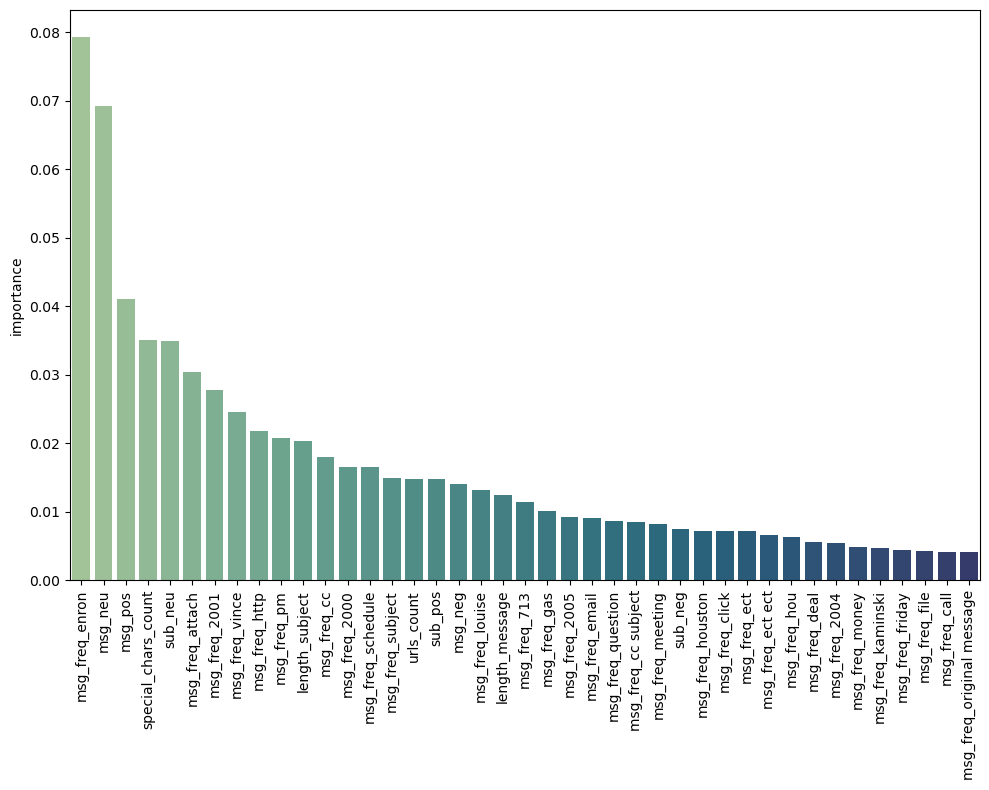

In [9]:
feature_importance = pd.DataFrame(rfc_final.feature_importances_, index=X.columns, columns=['importance'])

feature_importance = feature_importance[feature_importance['importance'] > 0.004]
feature_importance = feature_importance.sort_values(by='importance', ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
ax = sns.barplot(feature_importance, x=feature_importance.index, y=feature_importance['importance'], palette='crest')


plt.xticks(rotation=90)
plt.tight_layout()

# XGBoost

## Baseline Model Performance

In [10]:
import xgboost 
from xgboost import XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54)

xgb = XGBClassifier(device='cuda')

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)
print(classification_report(y_pred=y_pred, y_true=y_test))
print(f'Accuracy Training: {accuracy_score(y_train, y_pred_train)}')
print(f'Accuracy Testing: {accuracy_score(y_test, y_pred)}')

c:\Users\Brendan\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:46:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3274
           1       0.98      0.99      0.98      3235

    accuracy                           0.98      6509
   macro avg       0.98      0.98      0.98      6509
weighted avg       0.98      0.98      0.98      6509

Accuracy Training: 0.9924716727482236
Accuracy Testing: 0.9826394223383008


## Tuning

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54)

param_dist = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 2, 3, 4, 5],
}

scoring = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted')
}

random_search = RandomizedSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', device='cuda'),
                                   param_distributions=param_dist,
                                   n_iter=50,
                                   cv=5,       
                                   verbose=2,
                                   n_jobs=-1,
                                   scoring=scoring,
                                   refit='accuracy')

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learni...
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 500,
                                                         700, 1000],
                                        'scale_pos_weight': [1, 2, 3, 4, 5],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   refit='accuracy',
                   scoring={'accuracy': 'accuracy',
                            'f1': make_scorer(f1_score, average=weighted),
                            'precision': make_scorer(precision_score, average=weighted),
                            'recall': make_scorer(recall_score, average=weighted)},
                   verbose=2)

In [100]:
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_:.4f}")

Best parameters: {'subsample': 0.9, 'scale_pos_weight': 1, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.6}
Best score: 0.9817


In [11]:
model = XGBClassifier(subsample=0.9, scale_pos_weight=1, n_estimators=500, min_child_weight=2, max_depth=8, learning_rate=0.1, gamma=0.2, colsample_bytree=0.8, device='cuda')
kf = StratifiedKFold(n_splits=5)
# Store results
training_precision = []
testing_precision = []
i = 1

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on training and testing set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate precision
    train_precision = accuracy_score(y_train, y_train_pred)
    test_precision = accuracy_score(y_test, y_test_pred)
    training_precision.append(train_precision)
    testing_precision.append(test_precision)
    
    print(f'Fold {i}')
    print(f'Train accuray: {train_precision}')
    print(f'Test accuray: {test_precision}')
    i += 1
    
# Display results
print("\nAVERAGE RESULTS:")
print("Training accuray:", np.mean(training_precision))
print("Testing accuray:", np.mean(testing_precision))


Fold 1
Train accuray: 0.9990397541770694
Test accuray: 0.9734214165002304
Fold 2
Train accuray: 0.9983867870174765
Test accuray: 0.9784913197111692
Fold 3
Train accuray: 0.9990781640099865
Test accuray: 0.9798740205868797
Fold 4
Train accuray: 0.9986556558478971
Test accuray: 0.9786449531418037
Fold 5
Train accuray: 0.9991550161315103
Test accuray: 0.9794099569760295

AVERAGE RESULTS:
Training accuray: 0.9988630754367879
Testing accuray: 0.9779683333832224


## Final Model

In [12]:
from xgboost import XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54)

xgb_final = XGBClassifier(device='cuda')

xgb_final.fit(X_train, y_train)

y_pred = xgb_final.predict(X_test)
y_pred_train = xgb_final.predict(X_train)
print(classification_report(y_pred=y_pred, y_true=y_test))
print(f'Accuracy Training: {accuracy_score(y_train, y_pred_train)}')
print(f'Accuracy Testing: {accuracy_score(y_test, y_pred)}')

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3274
           1       0.98      0.99      0.98      3235

    accuracy                           0.98      6509
   macro avg       0.98      0.98      0.98      6509
weighted avg       0.98      0.98      0.98      6509

Accuracy Training: 0.9924716727482236
Accuracy Testing: 0.9826394223383008


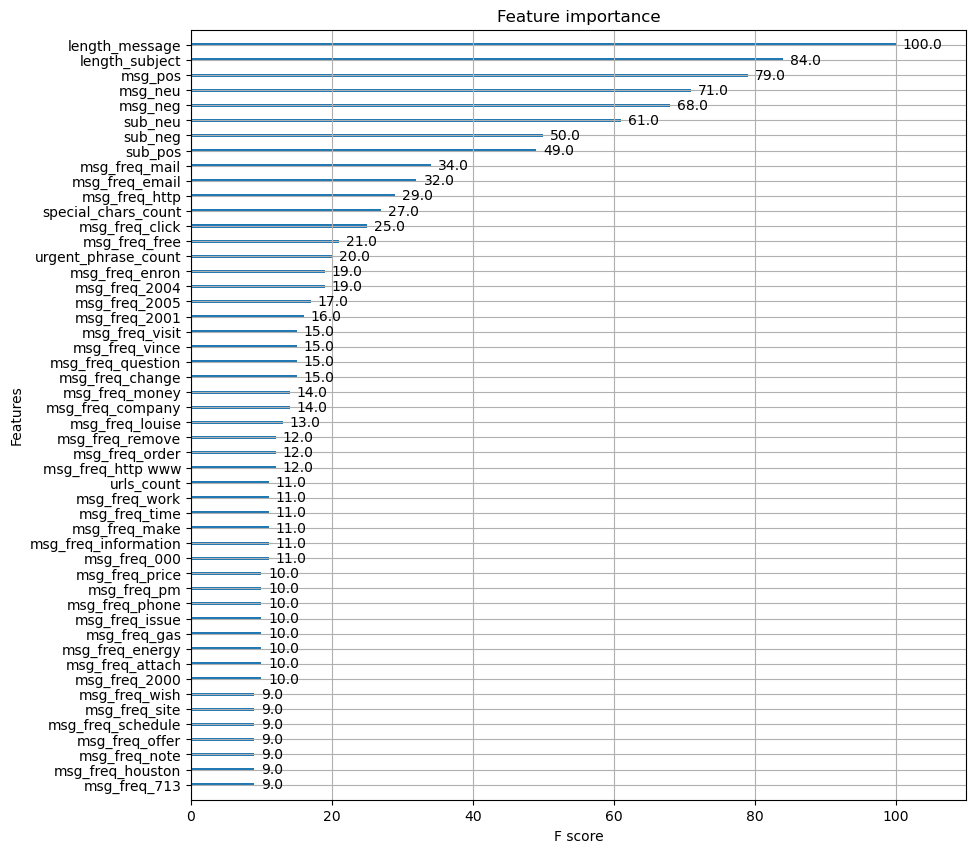

In [21]:
xgboost.plot_importance(xgb_final, max_num_features=50)
plt.rcParams['figure.figsize'] = [20, 20]

# Export Models

In [7]:
import joblib
import os

def export_model(model, filename, dir):
    save_path = os.path.join(dir, f'{filename}.pkl')
    joblib.dump(model, save_path)

In [8]:
export_model(rfc_final, 'rfc_model', 'models') 

In [107]:
# export_model(xgb_final, 'xgb_model', 'models')